Preprocessing of MTGSetB (Multi-Touch dataset B).
The ILG dataset is a collection of mono-stroke penbased gestures.
The goal of this file is to transform the online signal of each gesture to a 4D tensor:
- temporal (piece of motion, using a fixed length of curvilinear displacement ->$$thesholdCuDi$$ )
- X axis
- Y axis
- Stroke identification axis (use only one channel for the moment)

The trajectory of the gesture will be cumuled at each frame of the temporal axis, e.g.
the last frame will contains the full gesture, the first frame will contains only the first
segment (of length $$thesholdCuDi$$). A black image is added at the end of the gesture.

In [1]:
import math
import os
from typing import List, Tuple
import numpy as np
from skimage.draw import line_aa, line_nd
from utils.parsing import simple_structure_parsing
from matplotlib import pyplot as plt

pathOutputPreprocess = "C:\\workspace2\\Datasets\\2D\\MTG\\MTGSetB\\PreprocessedData\\"
pathOutputImages = "C:\\workspace2\\Datasets\\2D\\MTG\MTGSetB\\Images\\"
pathInputData = "C:\\workspace2\\Datasets\\2D\\MTG\MTGSetB\data\\"
separator = "\\"
actionFileName = "Actions.csv"
if not os.path.exists(pathOutputPreprocess):
    os.mkdir(pathOutputPreprocess)
    os.mkdir(pathOutputPreprocess+separator+"Train")
    os.mkdir(pathOutputPreprocess+separator+"Test")

Read config file

In [2]:
f = open("config.txt")
configParams = f.readlines()
f.close()
configParams = eval("\n".join(configParams))

multiplierCoord = configParams["multiplierCoord"]#all the coordinates will be multiplied by this value
thresholdCuDi = configParams["thresholdCuDi"]*(multiplierCoord) # value in pixel
dimensionsOutputImage = np.array(configParams["dimensionsOutputImage"]) # x and y dimension of output

## Read data from files

In [3]:
def readFileAndAddData(file:str, gestures: List[Tuple[List[List[Tuple[float,float,float,float]]],str]],multiplierCoord):
    """
    add the gestures of the 'file' in the 'gestures' list
    :param file: the file (.inkml) which contains gestures
    :param gestures: the list to fill with gestures
    :return: void
    """
    gesturesMultiStrokes: List[Tuple[List[List[Tuple[float,float,float,float]]],str]] = simple_structure_parsing(file,multiplierCoord,removeDuplicatedPoint=True)
    gesturesMultiStrokes = list(map(lambda sample : (sample[0],"A_02") if sample[1]=="A_01" else (sample[0],sample[1]),gesturesMultiStrokes))
    #gesture A01 and A02 is the same class
    gestures.extend(gesturesMultiStrokes)

gesturesTrain : List[Tuple[List[List[Tuple[float,float,float,float]]],str]] = []
gesturesTest : List[Tuple[List[List[Tuple[float,float,float,float]]],str]] = []

listFilesTest = os.listdir(pathInputData+"Test")
listFilesTrain = os.listdir(pathInputData+"Train")
print("Testing set")
for fileSample in listFilesTest:
    print(fileSample)
    readFileAndAddData(pathInputData+"Test"+separator+fileSample,gesturesTest,multiplierCoord)
print("Training set")
for fileSample in listFilesTrain:
    print(fileSample)
    readFileAndAddData(pathInputData+"Train"+separator+fileSample,gesturesTrain,multiplierCoord)
    readFileAndAddData(pathInputData+"Train"+separator+fileSample,gesturesTrain,multiplierCoord+0.01)

Testing set
003.inkml
006.inkml
008.inkml
009.inkml
010.inkml
012.inkml
dell2201_32_002.inkml
dell2202_32_001.inkml
dell2202_32_002.inkml
hp11_32_002.inkml
lenono2701_32_002.inkml
lenono2702_32_001.inkml
lenono2702_32_002.inkml
lenovo2701_46_001.inkml
samsung11_32_002.inkml
samsung11_32_004.inkml
samsung46_32_001.inkml
samsung46_46_001.inkml
Training set
001.inkml
004.inkml
005.inkml
007.inkml
011.inkml
013.inkml
dell2201_32_001.inkml
dell2201_46_001.inkml
dell2202_46_001.inkml
hp11_32_001.inkml
lenono2701_32_001.inkml
lenovo2702_46_001.inkml
samsung11_32_001.inkml
samsung11_32_003.inkml
samsung11_46_001.inkml


## Put each gesture in little pieces of fixed length

In [4]:
def segmentGestureInPiecesOfMovement(gesture:List[List[Tuple[float,float,float,float]]],thresholdCuDi,debug:bool) -> List[List[List[np.ndarray]]]:
    """
    :param gesture: Strokes[Points[Tuple[x,y,pressure,time]]
    :return:List[List[Strokes[array[x,y]]],
    [
        Segment1:[  Stroke1:[Point1,Point2], Stroke2:[Point3,Point4]
        ],
        Segment2:[Stroke1:[Point5,Point8], Stroke2:[Point,Point]
        ],....

    ]
    """


    def remodelingStrokesInOneOrderedByTimeWithStrokeID(gesture:List[List[Tuple[float,float,float,float]]])\
            ->Tuple[List[Tuple[float,float,float,float]],int]:
        """

        :param gesture: Strokes[Points[Tuple[x,y,pressure,time]]
        :return:List[Tuple[x,y,time,strokeID], ordered by time and the number of strokes
        """
        newListOrderedByTime:List[Tuple[float,float,float,float]] = []
        for idStroke,stroke in enumerate(gesture):
            pointsWithStrokeId = list(map(lambda point: (point[0],point[1],point[3],idStroke),stroke))
            newListOrderedByTime += pointsWithStrokeId # concat list

        newListOrderedByTime.sort(key=lambda point:point[2]) #sort by time
        return newListOrderedByTime,len(gesture)

    gesture, nbStrokes = remodelingStrokesInOneOrderedByTimeWithStrokeID(gesture)

    currentCuDi = 0
    currentIndexPoint = 0

    pieces : List[List[List[np.ndarray]]] = []
    currentListOfStrokesPoint:List[List[np.ndarray]] = [[] for _ in range(nbStrokes)]
    previousPoint = [0]*nbStrokes
    while currentIndexPoint<len(gesture):
        poin = gesture[currentIndexPoint]
        if debug:
            print("currentIndexPoint",currentIndexPoint,"poin[0:2]",poin[0:2])
            print("previousPoint[indexStrokeTmp]",previousPoint[poin[3]])

        timeCurrentPoint = poin[2]

        if(currentIndexPoint+1<len(gesture)):
            poinAft = gesture[currentIndexPoint+1]
            if poin[2]==poinAft[2] and poin[3]==poinAft[3]: # time and stroke
                currentIndexPoint+=1
                continue # if the next point is at the same time and same stroke, we take le next one, so next loop

        totalCuDiAtThisTime = 0
        pointsToDoSameTime = [] # should contains at most one point by stroke
        oldCurrentIndex = currentIndexPoint
        while currentIndexPoint<len(gesture): # to get all the points which have been done at the same time
            pointTmp = np.array(gesture[currentIndexPoint])
            timeTmp = pointTmp[2]

            if(timeCurrentPoint!=timeTmp): # the list is ordered by time
                break
            pointsToDoSameTime.append(pointTmp)
            coordTmp, indexStrokeTmp = pointTmp[0:2], int(pointTmp[3])
            prevPoint = previousPoint[indexStrokeTmp]
            try:
                if(prevPoint == 0): # will raise a ValueError if it's a np.array
                    # print("prevpoint is 0")
                    previousPoint[indexStrokeTmp] = coordTmp
                    prevPoint = coordTmp
            except ValueError: # prevpoint is really a point
                pass
            # print("coordTmp,prevPoint",coordTmp,prevPoint)
            # print("coordTmp-prevPoint",coordTmp-prevPoint)
            normDiff = np.linalg.norm(coordTmp-prevPoint)
            # print("normDiff",normDiff)
            totalCuDiAtThisTime += normDiff
            currentIndexPoint += 1
        currentIndexPoint -= 1


        # print("len(pointsToDoSameTime)",len(pointsToDoSameTime))
        newPointsToDoSameTime = []
        indexStrokeAlreadySelected = []
        # we keep only one value for each strokes at the same time (the last one)
        # this should happen, but it does in the data
        for i in range(len(pointsToDoSameTime)-1,-1,-1): # reversed loop to take the last point
            if pointsToDoSameTime[i][3] not in indexStrokeAlreadySelected:
                indexStrokeAlreadySelected.append(pointsToDoSameTime[i][3])
                newPointsToDoSameTime.append(pointsToDoSameTime[i])
        newPointsToDoSameTime.reverse() # on place
        pointsToDoSameTime= newPointsToDoSameTime


        assert len(pointsToDoSameTime) <= nbStrokes # was not always true because we have 808 493 60 35, 808 492 60 35, for the same stroke in data

        # all the points in pointsToDoSameTime have been done in the same time, they all need to be in the same segment
        # if it is over the treshold we interpolate for each point a new point

        if abs(currentCuDi+totalCuDiAtThisTime-thresholdCuDi)<0.00001 or currentCuDi+totalCuDiAtThisTime>=thresholdCuDi: # threshold reached almost perfectly
            for p in pointsToDoSameTime:
                indexStroke = int(p[3])
                currentListOfStrokesPoint[indexStroke].append(p[0:2])
            currentCuDi = 0
            pieces.append(currentListOfStrokesPoint)
            currentListOfStrokesPoint = [[] for _ in range(nbStrokes)]
            for p in pointsToDoSameTime:
                indexStroke = int(p[3])
                currentListOfStrokesPoint[indexStroke] = [p[0:2]] # add the pooints at starting point of next seg
                previousPoint[indexStroke] = p[0:2]
        else : # currentCuDi+totalCuDiAtThisTime<thresholdCuDi: # threshold not reached yet
            for p in pointsToDoSameTime:
                indexStroke = int(p[3])
                currentListOfStrokesPoint[indexStroke].append(p[0:2])
                previousPoint[indexStroke] = p[0:2]
            currentCuDi += totalCuDiAtThisTime

        # else: # over the threshold, in this case we interpolate linearly the 'perfect' (for each stroke) point to reach the threshold
        #     missValueTotal = thresholdCuDi-currentCuDi
        #     intermediatePoints = []
        #     for p in pointsToDoSameTime:
        #         indexStroke = int(p[3])
        #         norm = np.linalg.norm(p[0:2]-previousPoint[indexStroke])
        #         contribution = norm/totalCuDiAtThisTime
        #         print("-----")
        #         # print("norm",norm)
        #         vectorPerfectLength = (p[0:2]-previousPoint[indexStroke])/norm*contribution*missValueTotal \
        #             if norm!=0. else np.array([0.,0])
        #         # print("vectorPerfectLength",vectorPerfectLength)
        #         # print("previousPoint[indexStroke]",previousPoint[indexStroke])
        #         intermediatePoint = previousPoint[indexStroke]+vectorPerfectLength
        #         # print("intermediatePoint",intermediatePoint)
        #         currentListOfStrokesPoint[indexStroke].append(intermediatePoint)
        #         intermediatePoints.append(intermediatePoint)
        #     currentCuDi = 0
        #     pieces.append(currentListOfStrokesPoint)
        #     currentListOfStrokesPoint = [[] for _ in range(nbStrokes)]
        #     for i,p in enumerate(pointsToDoSameTime):
        #         indexStroke = int(p[3])
        #         currentListOfStrokesPoint[indexStroke] = [intermediatePoints[i]] # add the pooints at starting point of next seg
        #         previousPoint[indexStroke] = intermediatePoints[i]
        #     currentIndexPoint = oldCurrentIndex - 1 # to do the loop on the same 'coords' points which is not reached yet
        #     # print("return to ",currentIndexPoint+1)
        currentIndexPoint+=1

    # if there is some point at the end where the segments sum doesn't reach the threshold
    # we add them as another piece
    if any(list(map(lambda l: len(l)>1,currentListOfStrokesPoint))):
        pieces.append(currentListOfStrokesPoint)
    return pieces

gesturesSegmentsTest: List[Tuple[List[List[List[np.ndarray]]],str]] = []
gesturesSegmentsTrain: List[Tuple[List[List[List[np.ndarray]]],str]] = []
print("Testing set...",)
for i,gesture in enumerate(gesturesTest):
    if (i%500==0):
        print(i,"/",len(gesturesTest))
    gestureSegments: Tuple[List[List[List[np.ndarray]]],str] = (segmentGestureInPiecesOfMovement(gesture[0],thresholdCuDi,False), gesture[1])
    gesturesSegmentsTest.append(gestureSegments)
print("Done,",len(gesturesTest),"elements")
print("Training set...")
for i,gesture in enumerate(gesturesTrain):
    if (i%500==0):
        print(i,"/",len(gesturesTrain))
    gestureSegments: Tuple[List[List[List[np.ndarray]]],str] = (segmentGestureInPiecesOfMovement(gesture[0],thresholdCuDi,False), gesture[1])
    gesturesSegmentsTrain.append(gestureSegments)
print("Done",len(gesturesTrain),"elements")

Testing set...
0 / 4019
500 / 4019
1000 / 4019
1500 / 4019
2000 / 4019
2500 / 4019
3000 / 4019
3500 / 4019
4000 / 4019
Done, 4019 elements
Training set...
0 / 7278
500 / 7278
1000 / 7278
1500 / 7278
2000 / 7278
2500 / 7278
3000 / 7278
3500 / 7278
4000 / 7278
4500 / 7278
5000 / 7278
5500 / 7278
6000 / 7278
6500 / 7278
7000 / 7278
Done 7278 elements


### Exploration of the number of segments

In [5]:
count = [len(gesture[0]) for gesture in gesturesSegmentsTrain]
print(np.histogram(count))
fig, ax = plt.subplots()

_, _, _ = ax.hist(count, 30,)

ax.set_xlabel('Number of segment')
ax.set_ylabel('Density')
ax.set_title('Histogram of the number of segments in gestures(train set)')
count = [len(gesture[0]) for gesture in gesturesSegmentsTest]
plt.savefig("AfterDataAugmentationTrain.png")
fig, ax = plt.subplots()

_, _, _ = ax.hist(count, 30)

ax.set_xlabel('Number of segment')
ax.set_ylabel('Density')
ax.set_title('Histogram of the number of segments in gestures(test set)')
plt.savefig("AfterDataAugmentationTest.png")

(array([ 384, 2201, 2075, 1518,  684,  289,   88,   28,    8,    3],
      dtype=int64), array([ 1. ,  7.8, 14.6, 21.4, 28.2, 35. , 41.8, 48.6, 55.4, 62.2, 69. ]))


## Pixelisation of the gestures along the time

In [6]:
def pixelisationOfThePiecesOfGestures(gestureSegments: List[List[List[np.ndarray]]],id:int):
    """

    :param gestureSegments: Segments [ Strokes [ Points [x,y]]]
    :return:
    """
    center = dimensionsOutputImage/2.
    count=0
    gest1 = np.array([0.,0.])
    minX = 99999
    minY = 99999
    maxX = -9999
    maxY = -9999
    for stroke in gestureSegments[0]:
        for idPoint1 in range(0,len(stroke)):
            firstPoint = stroke[idPoint1]
            gest1 += firstPoint[0:2]
            minX = min(minX,firstPoint[0])
            minY = min(minY,firstPoint[1])
            maxY = max(maxY,firstPoint[1])
            maxX = max(maxX,firstPoint[0])
            count+=1
            break
    assert minX!=99999

    offSet = center-gest1/count
    marge = 5
    imagesAlongTime:List[np.ndarray[dimensionsOutputImage]] = [] # len(imagesAlongTime)==len(gestureSegments)
    imagesFingerPosAlongTime:List[np.ndarray[dimensionsOutputImage]] = [] # len(imagesAlongTime)==len(gestureSegments)
    image = np.zeros(shape=dimensionsOutputImage,dtype="bool")
    for idSeg,segment in enumerate(gestureSegments):
        imageLastPoint = np.zeros(shape=dimensionsOutputImage,dtype="bool")
        for stroke in segment:
            for idPoint1 in range(0,len(stroke)-1):
                shifted=False
                idPoint2 = idPoint1+1
                coordP1 = stroke[idPoint1][0:2]+offSet
                coordP2 = stroke[idPoint2][0:2]+offSet
                oldOffset=offSet
                if coordP2[0]>dimensionsOutputImage[0]-marge: # if X > border
                    #shift all the image to left
                    toShift = math.ceil(coordP2[0]-(dimensionsOutputImage[0]-marge))
                       # toShift = min(toShift,dimensionsOutputImage[0]-3)
                    if(toShift>dimensionsOutputImage[0]-marge):
                        coordP2[0] -= (toShift-(dimensionsOutputImage[0]-marge))
                        toShift = math.ceil(coordP2[0]-(dimensionsOutputImage[0]-marge))

                    offSet = offSet-[toShift,0]
                    minX-=toShift
                    shifted = True
                    toShift,axis = -toShift,0
                if coordP2[1]>dimensionsOutputImage[1]-marge:# if Y is < 1
                    toShift = (math.ceil(coordP2[1])-(dimensionsOutputImage[1]-marge))
                    # toShift = min(toShift,dimensionsOutputImage[1]-3)
                    if(toShift>dimensionsOutputImage[1]-marge):
                        coordP2[1] -= (toShift-(dimensionsOutputImage[1]-marge))
                        toShift = math.ceil(coordP2[1]-(dimensionsOutputImage[1]-marge))
                    # if(abs(toShift)>dimensionsOutputImage[1]):
                    #     coordP2[1] = dimensionsOutputImage[1]+dimensionsOutputImage[1]/2
                    #     toShift = math.ceil(coordP2[1]-(dimensionsOutputImage[1]-2))
                    minY-=toShift
                    offSet = offSet-[0,toShift]
                    shifted = True
                    toShift,axis = -toShift,1
                # if <0
                if coordP2[0]<0+marge:
                    toShift = -math.floor(coordP2[0])+marge
                    # toShift = max(toShift,-dimensionsOutputImage[0]+3)
                    if(toShift>dimensionsOutputImage[0]-marge):
                        coordP2[0] -= (dimensionsOutputImage[0]-marge-toShift)
                        toShift = -math.floor(coordP2[0])+marge
                    # if(abs(toShift)>dimensionsOutputImage[0]):
                    #     coordP2[0] = -dimensionsOutputImage[0]/2
                    #     toShift = -math.floor(coordP2[0])+2
                    # if maxX+toShift>dimensionsOutputImage[0]: #overflow case
                    #     print( Exception("Overlflow on right"))
                    maxX+=toShift
                    offSet = offSet+[toShift,0]
                    shifted,axis = True,0
                if coordP2[1]<0+marge:
                    toShift = -math.floor(coordP1[1])+marge
                    # toShift = max(toShift,-dimensionsOutputImage[1]+3)
                    if(toShift>dimensionsOutputImage[1]-marge):
                        coordP2[1] -= (dimensionsOutputImage[1]-marge-toShift)
                        toShift = -math.floor(coordP2[1])+marge
                    # if(abs(toShift)>dimensionsOutputImage[1]):
                    #     coordP2[1] = -dimensionsOutputImage[1]/2
                    #     toShift = -math.floor(coordP2[1])+2
                    maxY+=toShift
                    offSet = offSet+[0,toShift]
                    shifted,axis = True,1
                minX = min(coordP2[0],minX)
                maxX = max(coordP2[0],maxX)
                minY = min(coordP2[1],minY)
                maxY = min(coordP2[1],maxY)
                rr,cc,_ = line_aa(int(round(coordP1[0])),int(round(coordP1[1])),int(round(coordP2[0])),int(round(coordP2[1])))
                try:
                    if shifted:
                        shiftToUseForBlack = toShift
                        if abs(toShift)>dimensionsOutputImage[1]/4:
                            shiftToUseForBlack = int(dimensionsOutputImage[1]//4*abs(toShift)/toShift)  # little trick to avoid weird effect

                        #we put black at the opposite of the image in order to do the roll correctly
                        if axis==0:
                            if toShift > 0:
                                image[-shiftToUseForBlack:]= np.zeros([shiftToUseForBlack,dimensionsOutputImage[1]])
                            else:
                                image[:-shiftToUseForBlack]= np.zeros([-shiftToUseForBlack,dimensionsOutputImage[1]])
                        else:
                            if toShift > 0:
                                image[:,-shiftToUseForBlack:]= np.zeros([dimensionsOutputImage[1],shiftToUseForBlack])
                            else:
                                image[:,:-shiftToUseForBlack]= np.zeros([dimensionsOutputImage[1],-shiftToUseForBlack])
                        #draw segments
                        image[[r%(dimensionsOutputImage[0]) for r in rr],[c%(dimensionsOutputImage[1]) for c in cc]] = 1 # draw the line in the image
                        if (idPoint2==len(stroke)-1):
                            imageLastPoint[rr[-1]%(dimensionsOutputImage[0]),cc[-1]%(dimensionsOutputImage[1])] = 1 # draw the line in the image
                            imageLastPoint = np.roll(imageLastPoint,toShift,axis=axis)
                        #roll image (shift)
                        image = np.roll(image,toShift,axis=axis)
                    else:
                        image[[max(min(r,dimensionsOutputImage[0]-1),0) for r in rr],[max(min(c,dimensionsOutputImage[1]-1),0) for c in cc]] = 1
                        if (idPoint2==len(stroke)-1):
                            imageLastPoint[max(min(rr[-1],dimensionsOutputImage[0]-1),0),max(min(cc[-1],dimensionsOutputImage[1]-1),0)] = 1

                except Exception as e:
                    print("pb ",id)
                    # print(toShift," to shift ")
                    print("max",maxX,maxY,minX,minY)
                    raise e



        imagesAlongTime.append(np.copy(np.transpose(image)))
        imagesFingerPosAlongTime.append(np.copy(np.transpose(imageLastPoint)))
    imageBlack = np.transpose(np.zeros(shape=dimensionsOutputImage,dtype="bool")) #add a black image at end
    imagesAlongTime.append(np.copy(imageBlack))
    imagesFingerPosAlongTime.append(np.copy(imageBlack))
    return imagesAlongTime,imagesFingerPosAlongTime

### One exemple

In [7]:
idToTest  = 5246#371#3431#1607#1578 #1463 # 87 # 1600
segments = gesturesSegmentsTrain[idToTest][0]
firstGesture,firstPenPosGestureAlongTime = pixelisationOfThePiecesOfGestures(segments,idToTest)

In [8]:
len(gesturesSegmentsTrain[idToTest][0])

11

In [9]:
gesturesSegmentsTrain[idToTest][1]

'A_02'

In [10]:
%matplotlib inline
plt.gray()
fig, axs = plt.subplots(4, 4)
fig.tight_layout()
tt = 0
for i in range(4):
    for j in range(4):
        try:
            axs[i, j].imshow(firstGesture[tt]*255, interpolation='nearest')
        except IndexError:
            pass
        tt+=1

<Figure size 432x288 with 0 Axes>

In [11]:
plt.imshow(firstGesture[1]*255, interpolation='nearest')


### Create actions.csv which contains associations between name of class id

In [12]:
elemsTest = [gestureSegments[1] for gestureSegments in gesturesSegmentsTest]
elemsTrain = [gestureSegments[1] for gestureSegments in gesturesSegmentsTrain]
elemsTestSET = list(dict.fromkeys(elemsTest))
elemsTrainSET = list(dict.fromkeys(elemsTrain))
assert all(i in elemsTrainSET for i in elemsTestSET)
assert len(elemsTrainSET)==31
elemsTrainSET.sort()
dictAssoc = {}
associations = ""
for id,gesture in enumerate(elemsTrainSET):
    associations+= str(id)+";"+gesture+"\n"
    dictAssoc[gesture]=id
f = open(pathOutputPreprocess+actionFileName,"w+")
f.write(associations)
f.close()

### Explore frequency by class

Text(0.5, 0, 'Classe')

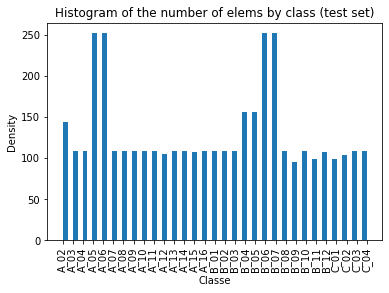

In [13]:
fig, ax = plt.subplots()
plt.xticks(rotation=90)

_, _, _ = ax.hist(elemsTrain, len(elemsTrainSET)*2-1)

ax.set_xlabel('Classe')
ax.set_ylabel('Density')
ax.set_title('Histogram of the number of elems by class (train set)')
count = [len(gesture[0]) for gesture in gesturesSegmentsTest]
fig, ax = plt.subplots()

_, _, _ = ax.hist(elemsTest, len(elemsTestSET)*2-1)

plt.xticks(rotation=90)
ax.set_ylabel('Density')
ax.set_title('Histogram of the number of elems by class (test set)')
ax.set_xlabel('Classe')



## Store the images in the preprocessed folder

In [14]:
saveImage = True
print("Testing set")
if saveImage:
    try:
        os.mkdir(pathOutputImages)
        os.mkdir(pathOutputImages+"Test")
        os.mkdir(pathOutputImages+"Train")
    except:
        pass

for i in range(len(gesturesSegmentsTest)):
    if(i%100==0):
        print(i,"on",len(gesturesSegmentsTest))
    images,fingerPos = pixelisationOfThePiecesOfGestures(gesturesSegmentsTest[i][0],i)
    img = np.expand_dims(images,axis=-1)
    imgFingerPos = np.expand_dims(fingerPos,axis=-1)
    finalImg2Chan = np.concatenate((img,imgFingerPos),axis=-1)
    name = str(i)+"_"+str(dictAssoc[gesturesSegmentsTest[i][1]])
    np.save(pathOutputPreprocess+"Test"+separator+name+".npy",finalImg2Chan)

    if saveImage:
        os.mkdir(pathOutputImages+"Test"+separator+name)
        for id,im in enumerate(img) :
            fing = imgFingerPos[id].astype("uint8")*255
            imCast = im.astype("uint8")*255
            imcolorR = ((imCast+fing)%256).astype("uint8")
            imcolorGB = (imCast-fing).astype("uint8")
            finalImg = np.concatenate((imcolorR,imcolorGB,imcolorGB),axis=-1)
            plt.imsave(pathOutputImages+"Test"+separator+name+separator+str(id)+".png",finalImg)


print("Done\nTraining set")
for i in range(len(gesturesSegmentsTrain)):
    if(i%100==0):
        print(i,"on",len(gesturesSegmentsTrain))
    images,fingerPos = pixelisationOfThePiecesOfGestures(gesturesSegmentsTrain[i][0],i)
    img = np.expand_dims(images,axis=-1)
    imgFingerPos = np.expand_dims(fingerPos,axis=-1)
    finalImg2Chan = np.concatenate((img,imgFingerPos),axis=-1)
    name = str(i)+"_"+str(dictAssoc[gesturesSegmentsTrain[i][1]])
    np.save(pathOutputPreprocess+"Train"+separator+name+".npy",finalImg2Chan)

    if saveImage:
        os.mkdir(pathOutputImages+"Train"+separator+name)
        for id,im in enumerate(img) :
            fing = imgFingerPos[id].astype("uint8")*255
            imCast = im.astype("uint8")*255
            imcolorR = ((imCast+fing)%256).astype("uint8")
            imcolorGB = (imCast-fing).astype("uint8")
            finalImg = np.concatenate((imcolorR,imcolorGB,imcolorGB),axis=-1)
            plt.imsave(pathOutputImages+"Train"+separator+name+separator+str(id)+".png",finalImg)


print("Done")

Testing set
0 on 4019
100 on 4019
200 on 4019
300 on 4019
400 on 4019
500 on 4019
600 on 4019
700 on 4019
800 on 4019
900 on 4019
1000 on 4019
1100 on 4019
1200 on 4019
1300 on 4019
1400 on 4019
1500 on 4019
1600 on 4019
1700 on 4019
1800 on 4019
1900 on 4019
2000 on 4019
2100 on 4019
2200 on 4019
2300 on 4019
2400 on 4019
2500 on 4019
2600 on 4019
2700 on 4019
2800 on 4019
2900 on 4019
3000 on 4019
3100 on 4019
3200 on 4019
3300 on 4019
3400 on 4019
3500 on 4019
3600 on 4019
3700 on 4019
3800 on 4019
3900 on 4019
4000 on 4019
Done
Training set
0 on 7278
100 on 7278
200 on 7278
300 on 7278
400 on 7278
500 on 7278
600 on 7278
700 on 7278
800 on 7278
900 on 7278
1000 on 7278
1100 on 7278
1200 on 7278
1300 on 7278
1400 on 7278
1500 on 7278
1600 on 7278
1700 on 7278
1800 on 7278
1900 on 7278
2000 on 7278
2100 on 7278
2200 on 7278
2300 on 7278
2400 on 7278
2500 on 7278
2600 on 7278
2700 on 7278
2800 on 7278
2900 on 7278
3000 on 7278
3100 on 7278
3200 on 7278
3300 on 7278
3400 on 7278
3500 o